In [1]:
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
from collections import Counter

import gensim
from gensim.models import Phrases

from tqdm.notebook import tqdm

# 1 Load Data

In [2]:
#### Load Data
# Create the list of brand name as the search key
# {"Fiat":["Nov 31, 2021", 6], "Mini":["Jun 9, 2018", 7], "VW":["Oct 14, 2018", 5], "Pg":["Feb 25, 2019", 7], "Tesla":["Aug 30, 2019", 7]}
dic_brand = {"Fiat":["Nov 20, 2022", 6], "Mini":["Jun 9, 2018", 7], "VW":["Oct 14, 2018", 5], "Pg":["Feb 25, 2019", 7], "Tesla":["Aug 30, 2019", 7]}
df_all = []
l_brand = []
date_launch = []
interval_launch = []
#### Load data by brand
for key, date in dic_brand.items():
# create paths for post and comment data
    path_comment = "/Data_Vis/" + key + "_senti_topic.csv"
    df_all.append(pd.read_csv(path_comment))
    l_brand.append(key)
    date_launch.append(pd.to_datetime(date[0], format="%b %d, %Y"))
    interval_launch.append(date[1])
print("Launch Date:", date_launch, "\n", "Launch intervals:", interval_launch)
df_all[0].info()

Launch Date: [Timestamp('2022-11-20 00:00:00'), Timestamp('2018-06-09 00:00:00'), Timestamp('2018-10-14 00:00:00'), Timestamp('2019-02-25 00:00:00'), Timestamp('2019-08-30 00:00:00')] 
 Launch intervals: [6, 7, 5, 7, 7]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      730 non-null    int64 
 1   Dominant_Topic  730 non-null    int64 
 2   Date            730 non-null    object
 3   Text            730 non-null    object
 4   label           730 non-null    object
dtypes: int64(2), object(3)
memory usage: 28.6+ KB


# 2 Text Tokenisation

In [3]:
#### Convert Date data type
# The list of dataframes that contain Date and Text
brand_index = 3
df_cmt = df_all[brand_index][['Date', 'Text', 'Dominant_Topic', 'label']]
df_cmt['Date'] = pd.to_datetime(df_cmt['Date'])

#### Cut the text clip out according to the interval
df_inter = df_cmt.loc[(df_cmt['Date']>date_launch[brand_index]) 
            & (df_cmt['Date']<=(date_launch[brand_index]+pd.DateOffset(months=interval_launch[brand_index])))]
print(min(df_inter['Date']), "to", max(df_inter['Date']))

2019-03-07 00:00:00 to 2019-09-13 00:00:00


C:\Users\xiaoc\AppData\Local\Temp\ipykernel_22340\1350910671.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cmt['Date'] = pd.to_datetime(df_cmt['Date'])


In [4]:
#### Define data preprocess function
#### Load spaCy package
nlp = spacy.load("en_core_web_sm")
# and token.lemma_.lower() not in {}
def preprocess(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha
            and token.lemma_.lower() not in {f"{l_brand[brand_index].lower()}","gaz","say","car","go","think","need",
                                             "thank","know","come","ev","peugeot","volkswagen"}]

#### Tokenise data with spaCy for the classifier data
tkns_docs_all = [preprocess(text) for text in tqdm(df_cmt["Text"])]
tkns_docs_inter = [preprocess(text) for text in tqdm(df_inter["Text"])]

#### Train model to capture bigram
bigram = Phrases(
    tkns_docs_all,
    min_count=3,
    threshold=1
)
tkns_docs_all_bi = [bigram[tkn] for tkn in tkns_docs_all]
tkns_docs_inter_bi = [bigram[tkn] for tkn in tkns_docs_inter]

  0%|          | 0/3174 [00:00<?, ?it/s]

  0%|          | 0/409 [00:00<?, ?it/s]

# 3 Visualisation

## 1 Top Frequent Words

C:\Users\xiaoc\AppData\Local\Temp\ipykernel_22340\686212982.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(df_bow_all['Token'], rotation=30)
C:\Users\xiaoc\AppData\Local\Temp\ipykernel_22340\686212982.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df_bow_inter['Token'], rotation=30)


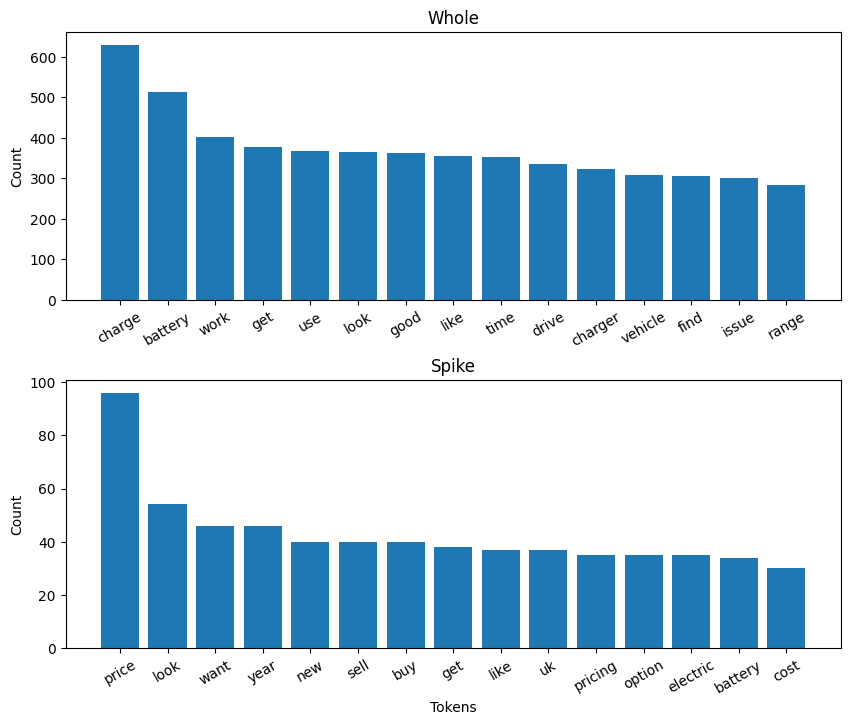

In [5]:
#### Check the most common words
flat_tkns_docs_all = [item for sublist in tkns_docs_all_bi for item in sublist]
l_cnt_all= Counter(flat_tkns_docs_all).most_common(15)
df_bow_all = pd.DataFrame(l_cnt_all, columns=["Token", "Count"])

flat_tkns_docs_inter = [item for sublist in tkns_docs_inter_bi for item in sublist]
l_cnt_inter= Counter(flat_tkns_docs_inter).most_common(15)
df_bow_inter = pd.DataFrame(l_cnt_inter, columns=["Token", "Count"])

#### Visualise the common tokens
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].bar(df_bow_all['Token'], df_bow_all['Count'])
axes[0].set_xticklabels(df_bow_all['Token'], rotation=30)
axes[0].set_ylabel('Count')
axes[0].set_title('Whole')
axes[1].bar(df_bow_inter['Token'], df_bow_inter['Count'])
axes[1].set_xticklabels(df_bow_inter['Token'], rotation=30)
axes[1].set_xlabel('Tokens')
axes[1].set_ylabel('Count')
axes[1].set_title('Spike')
fig.subplots_adjust(hspace=0.3)
plt.show()

## 2 Sentiment Score under Topics

In [6]:
#### Slice data after 2018
df_cmt = df_cmt.loc[(df_cmt['Date']>pd.to_datetime('2018-01-01 00:00:00'))]

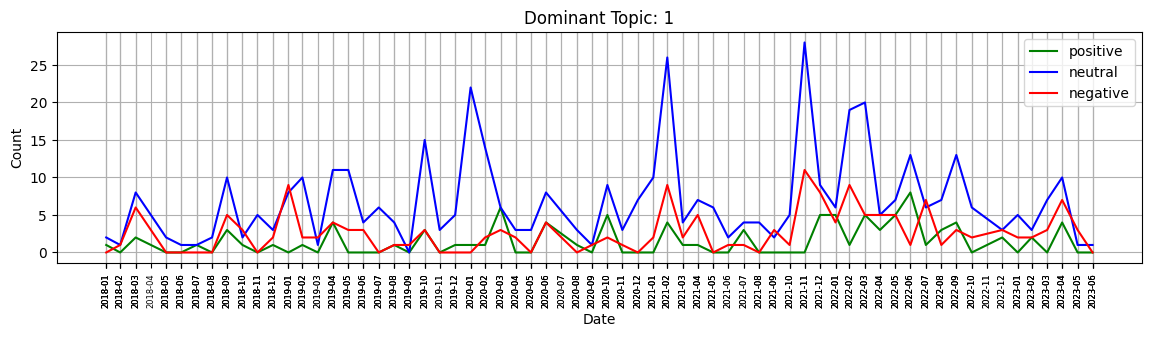

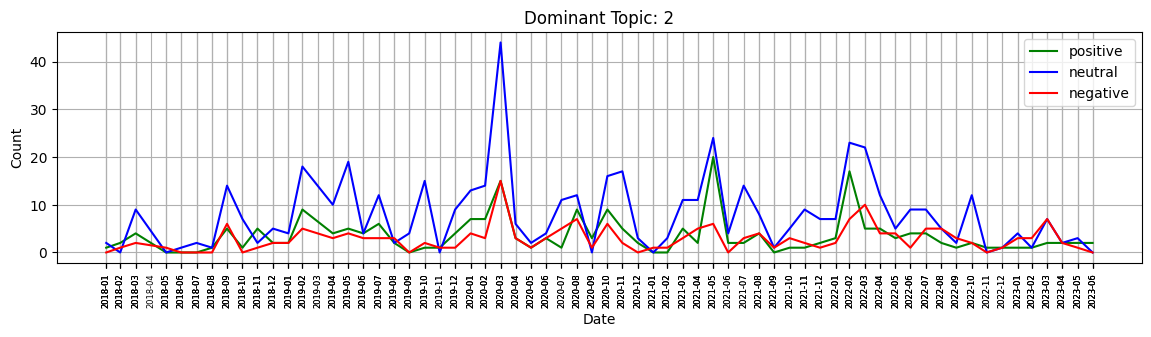

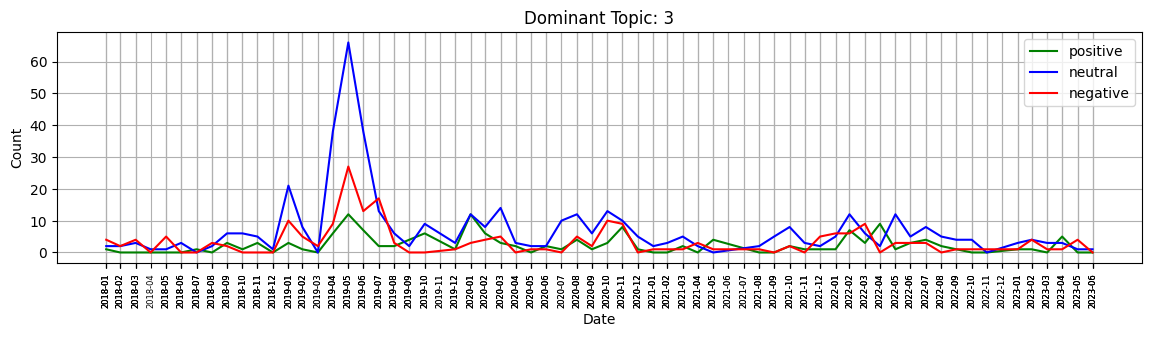

In [7]:
#### Different Sentiments under each Topic
df_label = df_cmt.set_index('Date')
# Resample data to monthly frequency

# Group data
grouped_0 = df_label.groupby([pd.Grouper(freq='M'), 'Dominant_Topic', 'label']).size().unstack().reset_index()
# grouped_0["Date"] = grouped_0["Date"].dt.strftime('%Y-%m')
# grouped_0['Date'] = pd.to_datetime(grouped_0['Date'])
gropued_0 = grouped_0.sort_values('Date')
grouped_0 = grouped_0.fillna(0)
# Unique topics
topics = df_label['Dominant_Topic'].unique()

# Colors for each label
color_map = {
    'positive': 'green',
    'neutral': 'blue',
    'negative': 'red'
}

for topic in topics:
    plt.figure(figsize=(14, 3))
    
    for label, color in color_map.items():
        if label in grouped_0.columns:
            plt.plot(grouped_0.loc[grouped_0['Dominant_Topic'] == topic, 'Date'],
                     grouped_0.loc[grouped_0['Dominant_Topic'] == topic, label],
                     label=label, color=color)
            
    plt.title(f'Dominant Topic: {topic+1}')
    plt.xticks(grouped_0['Date'])
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.tick_params(axis='x', labelsize=6, rotation = 90)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    #plt.tight_layout()
    plt.show()


C:\Users\xiaoc\AppData\Local\Temp\ipykernel_22340\2601484284.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_score['label'] = df_score['label'].map(sentiment_map)


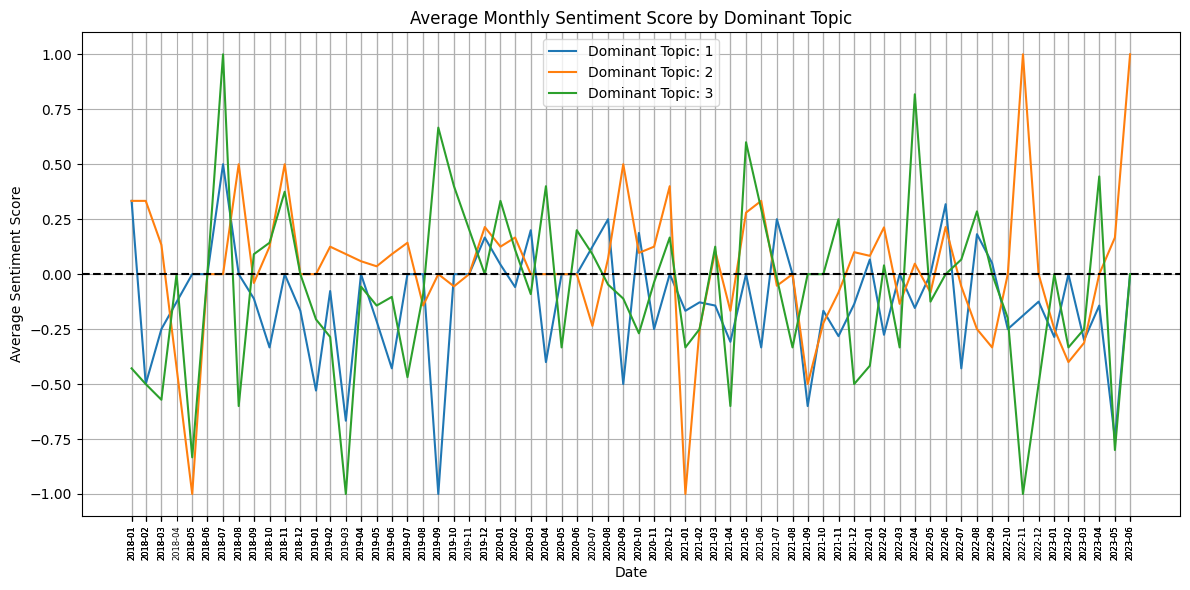

In [8]:
#### Added-up Sentiment Score
df_score = df_cmt[['Date', 'Dominant_Topic', 'label']]
#df_score = df_score.set_index('Date')
# Mapping sentiments to scores
sentiment_map= {'positive': 1, 'neutral': 0, 'negative': -1}
df_score['label'] = df_score['label'].map(sentiment_map)
# Compute the average sentiment score
grouped_1 = df_score.groupby([pd.Grouper(key='Date', freq='M'), 'Dominant_Topic']).mean().reset_index()
#grouped_1 = df_score.groupby([pd.Grouper(freq='M'), 'Dominant_Topic']).mean().reset_index()
# grouped_1["Date"] = grouped_1["Date"].dt.strftime('%Y-%m')
# grouped_1['Date'] = pd.to_datetime(grouped_1['Date'])
gropued_1 = grouped_1.sort_values('Date')
grouped_1 = grouped_1.fillna(0)

# Plotting
plt.figure(figsize=(12, 6))

for topic in grouped_1['Dominant_Topic'].unique():
    subset = grouped_1[grouped_1['Dominant_Topic'] == topic]
    plt.plot(subset['Date'], subset['label'], label=f'Dominant Topic: {topic+1}')

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Average Monthly Sentiment Score by Dominant Topic')
plt.xticks(grouped_1['Date'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.tick_params(axis='x', labelsize=6, rotation = 90)
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()